# 04 - Applied ML

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx
import itertools

from sklearn import linear_model
from sklearn import metrics
from networkx.algorithms import bipartite
from matplotlib.pyplot import cm
from operator import itemgetter

%matplotlib inline
sns.set(style="ticks")

## Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [2]:
df = pd.read_csv('lalonde.csv').set_index('id')

Let's make a categorical feature for the race.

In [3]:
df['race'] = 'white'
df.loc[df['black'] == 1, 'race'] = 'black'
df.loc[df['hispan'] == 1, 'race'] = 'hispanic'
df['race'] = df['race'].astype('category')

In [4]:
df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,race
id,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,black
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,hispanic
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,black
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,black
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,black


### 1. A naive analysis

_Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization")._

_What might a naive "researcher" conclude from this superficial analysis?_


In [5]:
print('Treated group : {} individuals'.format(len(df.loc[df.treat == 1])))
print('Control group : {} individuals'.format(len(df.loc[df.treat == 0])))

Treated group : 185 individuals
Control group : 429 individuals


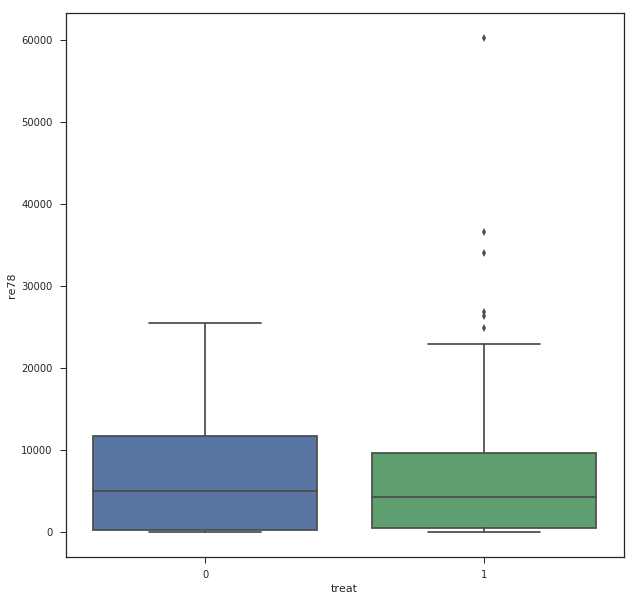

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
sns.boxplot(x="treat", y="re78", data=df, ax=ax)

This boxplots show that the distribution of the treated group revenue is 'under' the distribution of the control group, meaning it has lower median, quartiles and quantiles. 

Let's print some stats:

In [7]:
print("Control group:")
print(df[df['treat'] == 0]['re78'].mean())
print('')
print("Treated group:")
print(df[df['treat'] == 1]['re78'].mean())

Control group:
6984.16974231

Treated group:
6349.14353027


We see that the mean of the treated group is bellow the mean of the control group. A naive researcher would conclude that the training program has a negative effect on the treated person. Indeed their revenue is lower than the one of the control group.

### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

#### Distribution of mean revenues

In [8]:
df_mean_group = df.groupby('treat').mean().round().astype(int)
display(df_mean_group[['re74','re75','re78']])

,re74,re75,re78
treat,,,
0,5619,2466,6984
1,2096,1532,6349


It seems that there has been a drop in the mean income of both groups between 74 and 75. However, in spite of this drop, it seems that the treated group has had lower revenues than the control group on average in year 74 and 75. This gives us a hint that **the two groups are not comparable**.

We now also want to show the means and standard deviations of the salary of treated and non-treated people before in all years:

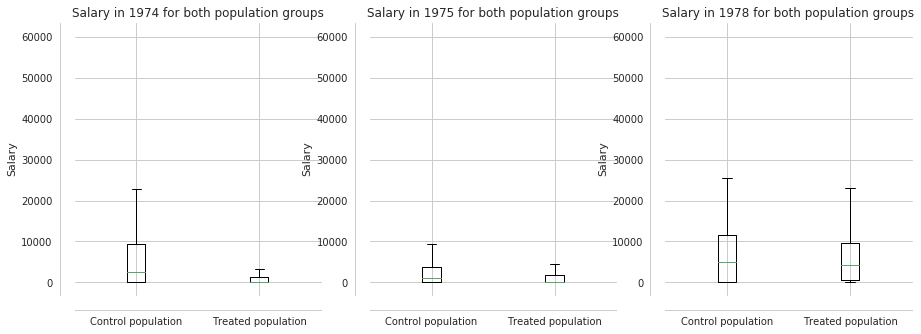

In [9]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1,3,sharey=True)
fig.set_size_inches(15,5)


cols = ['re74','re75','re78']
years = ['1974','1975','1978']

for i in range(3): # 0 = treated (axis 0), 1 = non-treated (axis 1)
    axes[i].boxplot([df.loc[df.treat==0, cols[i]].values, df.loc[df.treat==1, cols[i]].values],showfliers=True)
    sns.despine(offset=15, trim=False)
    axes[i].set_xticklabels(['Control population', 'Treated population'])
    axes[i].set_title('Salary in ' + str(years[i]) + ' for both population groups')
    axes[i].set_ylabel('Salary') # TODO annual?

This is further material to support the hypothesis that the two groups are not balanced. Now let's look at the distribution of the features

#### Distributions of features

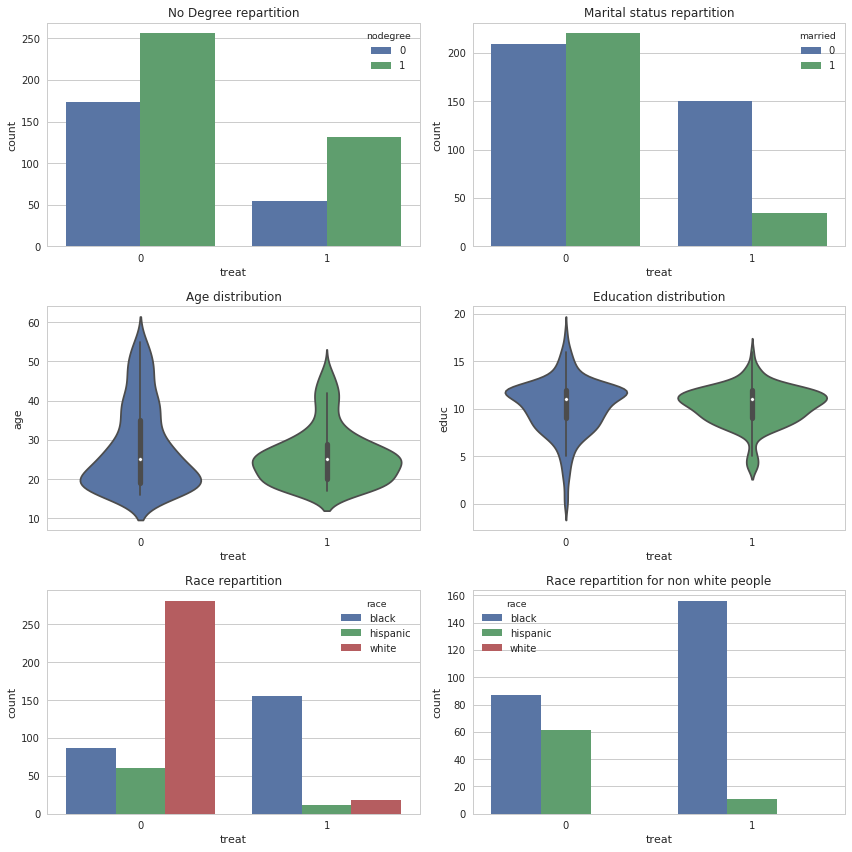

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

ax[0, 0].set_title("No Degree repartition")
sns.countplot(x='treat', hue='nodegree', data=df, ax=ax[0, 0])

ax[0, 1].set_title("Marital status repartition")
sns.countplot(x='treat', hue='married', data=df, ax=ax[0,1])

ax[1, 0].set_title("Age distribution")
sns.violinplot(x='treat', y='age', data=df, ax=ax[1, 0])

ax[1, 1].set_title("Education distribution")
sns.violinplot(x='treat', y='educ', data=df, ax=ax[1, 1])

ax[2, 0].set_title("Race repartition")
sns.countplot(x='treat', hue='race', data=df, ax=ax[2, 0])

ax[2, 1].set_title("Race repartition for non white people")
sns.countplot(x='treat', hue='race', data=df.loc[df.race != 'white', ['treat', 'race']], ax=ax[2, 1])

plt.tight_layout()
plt.show()

Following observations can be made:
- There are almost no married people in the treated group.
- The study seems to prefer more aged people for the treated group. The education is fairly similar in both groups
- We see a clear racial bias in the design of the study: there are almost no white people in treated group and an overweighing proportion of black people in treated group.

#### Means of features

As the means seem to suggest, the salaries for the treated group are still lower than the control group after treatment, thus one could be led to believe that the treatment is inefficient.

However, looking at the _differences_ between the treated and non-treated groups, we see that they become smaller after treatment:

In [11]:
# show revenue means
df_mean_group = df.groupby('treat').mean().round(1)
display(df_mean_group)

# show revenue differences between groups for each year
diff_t_nt_74 = df_mean_group.loc[0].re74 - df_mean_group.loc[1].re74
diff_t_nt_75 = df_mean_group.loc[0].re75 - df_mean_group.loc[1].re75
diff_t_nt_78 = df_mean_group.loc[0].re78 - df_mean_group.loc[1].re78
print("Difference between groups in 1974: %.1f " % diff_t_nt_74)
print("Difference between groups in 1975: %.1f " % diff_t_nt_75)
print("Difference between groups in 1978: %.1f " % diff_t_nt_78)

,age,educ,black,hispan,married,nodegree,re74,re75,re78
treat,,,,,,,,,
0,28.0,10.2,0.2,0.1,0.5,0.6,5619.2,2466.5,6984.2
1,25.8,10.3,0.8,0.1,0.2,0.7,2095.6,1532.1,6349.1


Difference between groups in 1974: 3523.6 
Difference between groups in 1975: 934.4 
Difference between groups in 1978: 635.1 


Indeed, the difference between the groups got smaller from 1974 to 1978, although salaries got higher on avarage for both groups.

Globally, we can also visualize the correlation between variables, and especially the correlation between the assignment to the treat group and other variables (first column):

#### Correlation matrix

In [12]:
def get_corr_matrix(df, mask_diag=True, f_size=(8, 8)):
    
    f, ax = plt.subplots(figsize=f_size)
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    if mask_diag:
        mask[np.triu_indices_from(mask)] = True

    sns.heatmap(corr, mask=mask, cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax, annot=True)
    ax.set_xticklabels(df.columns, rotation=40, horizontalalignment='right')
    plt.show()

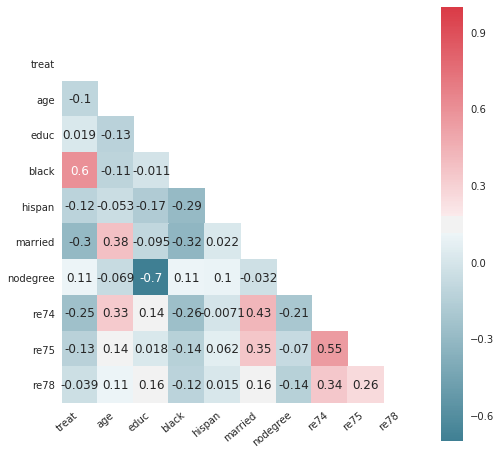

In [13]:
get_corr_matrix(df, mask_diag = True)

The correlation matrix confirms the assumption that `black` and `married` are two features that are correlated with `treat`. There is also a weak correlation (`-0.25`) between the revenues in 1974 and the assignment. Black, unmarried people with low salaries are thus more likely to be in the control group.

All those observation show that the control and treated groups are not balanced, meaning that we cannot draw any conclusion just by naively looking at the stats after the treatment. It does not mean that the naive conclusion is false, it means that there is no proof that it is right. We need a further analysis to balance the two groups.

### 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

#### Hypothesis

Following people seem to have been favoured for treatment
- Black people (84% proportion treated vs 20% proportion non-treated);
- Unmarried people (19% vs 60%);
- People with lower incomes in 1974 in particular.

#### Logistic model to compute propensity scores

As "pre-treatment" features, we select all the given features except for `treat` and `re78` (outcome variables).

In [14]:
# logistic regression
clf = linear_model.LogisticRegression()

# prepare the data
# discard non pre-treatment features
X = np.asarray(df.drop(['treat','re78', 'race'], axis=1).values)
# get the labels
y = np.asarray(df['treat'].values)

# fit the logistic regression classifier
clf.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
# get the probabilty that predicted label is 1 (treatement) (the propensity scores)
prop_scores = clf.predict_proba(X)[:, 1]

In [16]:
# insert probabilities to corresponding points in dataframe
df['propensity_score'] = prop_scores

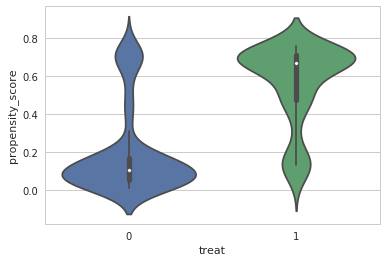

In [17]:
sns.violinplot(x='treat', y='propensity_score', data=df)

The plot shows that the propensity scores of the treated group are way higher than the one of the control group. The data set is not balanced.

### 4. Balancing the dataset via matching

_Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)_

_Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized._

_After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control)._

_Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?_

We will create a bipartite graph whose left nodes contain the indexes of people having been treated and as a right nodes contain indexes of people who have not been treated. We will connect all left and right nodes by the weight, which we calculate as the absolute difference between their propensities to be treated. Since `networkx` offers no way to minimize the weights, we will simply take the _negative_ difference and then use edge weight maximization.

In [18]:
nodes_control = df.index[df['treat']==0]
nodes_treated = df.index[df['treat']==1]

In [19]:
y = df['treat']

We build a bipartite graph by adding control nodes and treated nodes. The edges between the two sides are weighted by **minus** the absolute difference of propensity scores. Indeed, we then look for a Max weight matching of the bipartite graph so that will be the matching minimizing the sum of **plus** absolute differences of propensity scores.

In [20]:
B = nx.Graph()

# add nodes
B.add_nodes_from(nodes_treated, bipartite = 0)
B.add_nodes_from(nodes_control, bipartite = 1)

# add edges and weights
for ind_treated, node_treated in enumerate(nodes_treated):
    for ind_control, node_control in enumerate(nodes_control):
        # compute the edge weight
        propensity_diff = -abs(prop_scores[y==1][ind_treated] - prop_scores[y==0][ind_control])
        # add the edge
        B.add_edge(node_treated, node_control, weight = propensity_diff)

print("Graph is fully connected: " + str(nx.is_connected(B)))
print("Graph is bipartite: " + str(nx.is_bipartite(B)))

Graph is fully connected: True
Graph is bipartite: True


In [21]:
print('Number of nodes: {}'.format(len(B.nodes())))
print('Number of edges: {}'.format(len(B.edges())))

Number of nodes: 614
Number of edges: 79365


Notice: the total number of nodes in the graph corresponds to the total rows in the DataFrame and the number of edges is the product of the sizes of treat and control group.

In [22]:
max_matching = nx.bipartite.maximum_matching(B)

The dictionnary `max_matching` contains the matching in both ways. We want to keep only the keys that belong to the treat group.

In [23]:
matching = {}
for key in max_matching.keys():
    if df.loc[key, 'treat'] == 1:
        matching[key] = max_matching[key]

In [24]:
len(matching)

185

Notice that the length of the matching is the minimum of the size of treat and control group. We managed to match all the members of the treated group with a member of the control group.

#### Distribution of propensity scores of the balanced dataset

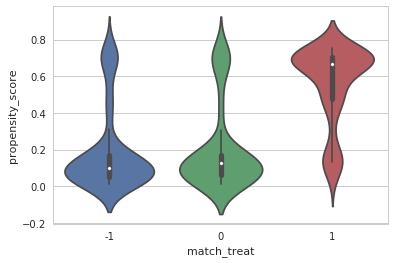

In [25]:
# TODO show propensity to be treated for both groups
df['match_treat'] = -1
df.loc[matching.keys(),'match_treat'] = 1
df.loc[matching.values(),'match_treat'] = 0

sns.violinplot(x='match_treat', y='propensity_score', data=df)

Propensity score distributions for the two groups 0 and 1 seem really different. The propensity scores are not balanced yet. 

-1 are propensity scores of individuals who haven't been able to be matched to group 1. It seems that the control group is still more balanced with unmatched individuals than with the treated group.

#### Distribution of the features

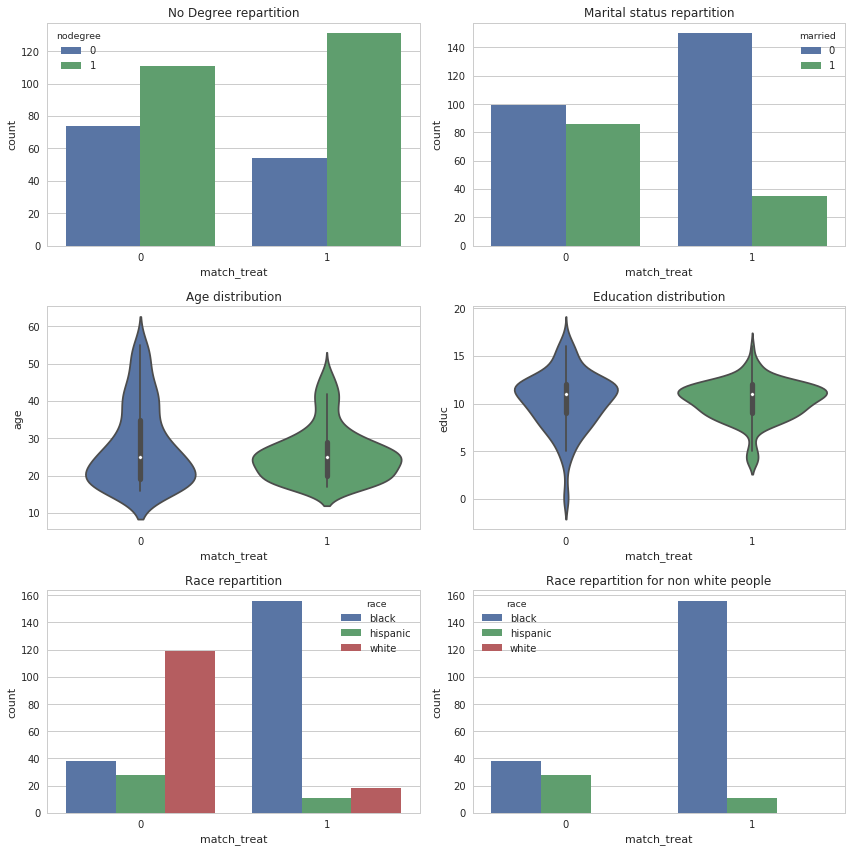

In [26]:
df_tmp = df.loc[df.match_treat != -1]
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

ax[0, 0].set_title("No Degree repartition")
sns.countplot(x='match_treat', hue='nodegree', data=df_tmp, ax=ax[0, 0])

ax[0, 1].set_title("Marital status repartition")
sns.countplot(x='match_treat', hue='married', data=df_tmp, ax=ax[0,1])

ax[1, 0].set_title("Age distribution")
sns.violinplot(x='match_treat', y='age', data=df_tmp, ax=ax[1, 0])

ax[1, 1].set_title("Education distribution")
sns.violinplot(x='match_treat', y='educ', data=df_tmp, ax=ax[1, 1])

ax[2, 0].set_title("Race repartition")
sns.countplot(x='match_treat', hue='race', data=df_tmp, ax=ax[2, 0])

ax[2, 1].set_title("Race repartition for non white people")
sns.countplot(x='match_treat', hue='race', data=df_tmp.loc[df.race != 'white', ['match_treat', 'race']], ax=ax[2, 1])

plt.tight_layout()
plt.show()

Marital statues and race repartition are still not balanced. This needs to be improved.

#### Conclusion:

We saw that both the propensity score and feature distribution are not balanced by this matching. We need to balance the groups further.

### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.

We build the same graph as before but now we only add edges between the nodes that have the same race and the same marital status.

In [27]:
B = nx.Graph()
y = df['treat']
# add nodes
B.add_nodes_from(nodes_treated, bipartite = 0)
B.add_nodes_from(nodes_control, bipartite = 1)

# add edges and weights
for ind_treated, node_treated in enumerate(nodes_treated):
    for ind_control, node_control in enumerate(nodes_control):
        if df.loc[node_treated, 'race'] == df.loc[node_control, 'race'] and df.loc[node_treated, 'married'] == df.loc[node_control, 'married']:
            propensity_diff = -abs(prop_scores[y==1][ind_treated] - prop_scores[y==0][ind_control])
            B.add_edge(node_treated, node_control, weight = propensity_diff)

print("Graph is fully connected: " + str(nx.is_connected(B)))
print("Graph is bipartite: " + str(nx.is_bipartite(B)))

Graph is fully connected: False
Graph is bipartite: True


In [28]:
print('Number of nodes: {}'.format(len(B.nodes())))
print('Number of edges: {}'.format(len(B.edges())))

Number of nodes: 614
Number of edges: 11165


The graph is not fully connected anymore. Let's see if each node as at least one neighbor.

In [29]:
nx.isolate.number_of_isolates(B)

0

No node is isolated so we might be able to find a matching. Let's look at the graph component by component.

In [30]:
matching = {}
for component in list(nx.connected_component_subgraphs(B)):
    max_matching = nx.bipartite.maximum_matching(component, top_nodes=set(component.nodes()).intersection(df.loc[df.treat == 1].index))
    for key in max_matching.keys():
        if df.loc[key, 'treat'] == 1:
            matching[key] = max_matching[key]
len(matching)

116

We managed to match only 116 individuals of each group. That is because those groups are not populated the same way. For example there are not enough black people in the control group to match all the black people of the treated group. (See below)

In [31]:
print('Number of black people in the control group : {}'.format(len(df.loc[df.treat == 0].loc[df.race == 'black'])))
print('Number of black people in the treated group : {}'.format(len(df.loc[df.treat == 1].loc[df.race == 'black'])))

Number of black people in the control group : 87
Number of black people in the treated group : 156


#### Distribution of propensity scores of the balanced dataset

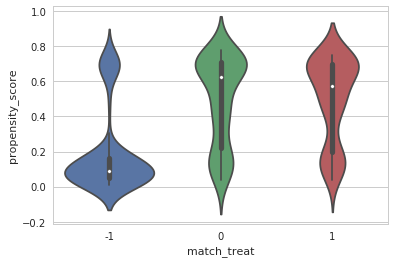

In [32]:
df['match_treat'] = -1
df.loc[matching.keys(),'match_treat'] = 1
df.loc[matching.values(),'match_treat'] = 0

sns.violinplot(x='match_treat', y='propensity_score', data=df)

Propensity scores distribution for the two groups 0 and 1 not seem more balanced. Let's look now if the features distribution is balanced.

#### Distribution of the features

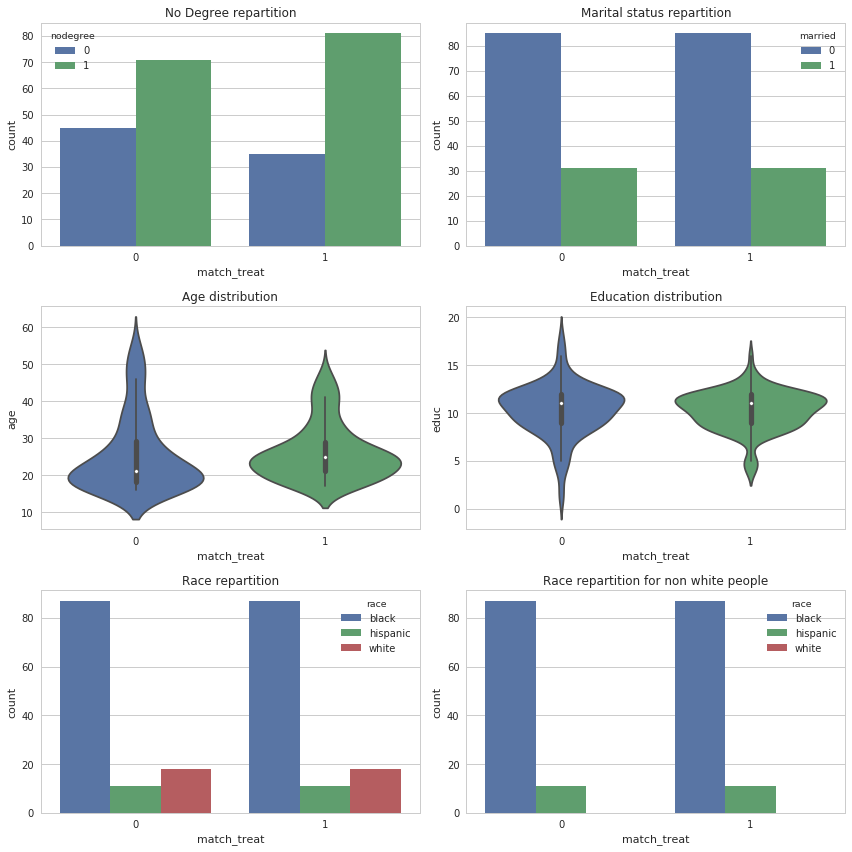

In [33]:
df_tmp = df.loc[df.match_treat != -1]
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

ax[0, 0].set_title("No Degree repartition")
sns.countplot(x='match_treat', hue='nodegree', data=df_tmp, ax=ax[0, 0])

ax[0, 1].set_title("Marital status repartition")
sns.countplot(x='match_treat', hue='married', data=df_tmp, ax=ax[0,1])

ax[1, 0].set_title("Age distribution")
sns.violinplot(x='match_treat', y='age', data=df_tmp, ax=ax[1, 0])

ax[1, 1].set_title("Education distribution")
sns.violinplot(x='match_treat', y='educ', data=df_tmp, ax=ax[1, 1])

ax[2, 0].set_title("Race repartition")
sns.countplot(x='match_treat', hue='race', data=df_tmp, ax=ax[2, 0])

ax[2, 1].set_title("Race repartition for non white people")
sns.countplot(x='match_treat', hue='race', data=df_tmp.loc[df.race != 'white', ['match_treat', 'race']], ax=ax[2, 1])

plt.tight_layout()
plt.show()

Now the feature distribution seems balanced, especially for marital status and race on which we did the matching (minor differences remain with regards to the age and education distribution). We can now have a less naive look at the results of the study.

### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

#### Distribution of the revenues

First, we want to show again box-plots of the distributions of the salary of treated and non-treated people before in all years (**using the matching**):

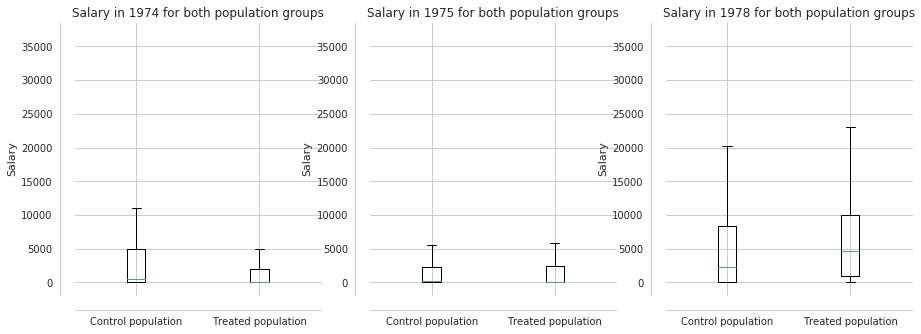

In [34]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1,3,sharey=True)
fig.set_size_inches(15,5)

cols = ['re74','re75','re78']
years = ['1974','1975','1978']

for i in range(3): # 0 = treated (axis 0), 1 = non-treated (axis 1)
    axes[i].boxplot([df.loc[df.match_treat==0, cols[i]].values, df.loc[df.match_treat==1, cols[i]].values],showfliers=True)
    sns.despine(offset=15, trim=False)
    axes[i].set_xticklabels(['Control population', 'Treated population'])
    axes[i].set_title('Salary in ' + str(years[i]) + ' for both population groups')
    axes[i].set_ylabel('Salary') # TODO annual?

Interestingly, while the control group had higher revenues in the 1974 and 1975, this is now not the case anymore after treatment! The pre-treatment earnings still aren't well balanced between the groups, but one can ask whether this has an effect on the results of the study. Indeed, it seems very difficult to match all variables at once. 

The absolute values are as follows:

In [35]:
print('Treated group : {} individuals'.format(len(df.loc[df.match_treat == 1])))
print('Control group : {} individuals'.format(len(df.loc[df.match_treat == 0])))

Treated group : 116 individuals
Control group : 116 individuals


In [36]:
# show revenue means
df_mean_matched = df.groupby('match_treat').mean().round(1)
display(df_mean_matched)

diff_74 = df_mean_matched.loc[1,'re74'] - df_mean_matched.loc[0,'re74']
diff_75 = df_mean_matched.loc[1,'re75'] - df_mean_matched.loc[0,'re75']
diff_78 = df_mean_matched.loc[1,'re78'] - df_mean_matched.loc[0,'re78']
print("difference treated - non-treated 1974: %.1f" % diff_74)
print("difference treated - non-treated 1975: %.1f" % diff_75)
print("difference treated - non-treated 1978: %.1f" % diff_78)

# show revenue differences between groups for each year

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
match_treat,,,,,,,,,,,
-1,0.2,28.3,10.2,0.2,0.1,0.5,0.6,5635.1,2413.9,7305.1,0.2
0,0.0,25.5,10.4,0.8,0.1,0.3,0.6,3154.8,1818.6,5095.7,0.5
1,1.0,26.1,10.3,0.8,0.1,0.3,0.7,2411.9,1797.1,6803.1,0.5


difference treated - non-treated 1974: -742.9
difference treated - non-treated 1975: -21.5
difference treated - non-treated 1978: 1707.4


The table above shows the mean revenues for matched people of the treated group (1) with their matched pairs of non-treated people (1). We can conclude that the revenue difference between the matched group has changed before and after the treatment and thus **the treatment seems to have had a positive effect on the participants** (remains to be proven whether this difference is significant)! This is now a less naive conclusion than the first one.

The major drawback still seems to be the unequal distribution of salaries before the treatment. This could be explained by an **unobserved covariate**.

However, this came at the cost of reducing the number of matches (only 116 pairs), which improves the quality assignment of participants to treatment and control group, but at the same time reduces the reliability of the interpretation of the results.

## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

2. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import ssl # avoid error messages during download
ssl._create_default_https_context = ssl._create_unverified_context

#### Import the data

In [38]:
newsgroups_train = fetch_20newsgroups(subset='train')

In [39]:
def plot_confusion_matrix(mat, figsize=(10,10)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(mat,xticklabels=newsgroups_train.target_names, yticklabels=newsgroups_train.target_names,
                cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax, annot=True)
    ax.set_xticklabels(newsgroups_train.target_names, rotation=40, horizontalalignment='right')
    plt.show()

#### Compute the tf-idf matrix

In [40]:
# declare the vectorizer
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)
# compute the td-idf features
tfidf = vectorizer.fit_transform(newsgroups_train['data'])
# get the correspondance between features and words
feature_names = vectorizer.get_feature_names()

#### Split data set in training and validation tests (80%, 20%) 

First, we split our data in a training set (80%) and a validation set (20%). We will split the dataset again in a training and test set during k-fold cross-validation, using a (k-1)/k-th  of the training set for training and 1/k-th for testing.

We will then apply the model to the totally unseen data (about 20%).

In [41]:
# split in train (80%) and tmp (20%)
X_train, X_val, y_train, y_val = train_test_split(tfidf, newsgroups_train['target'], train_size=.8, test_size = .2,
                                                  random_state=42)

print(X_train.shape, X_val.shape)

(9051, 129796) (2263, 129796)


#### Train the random forest

First we use the default parameters.

In [42]:
clf = RandomForestClassifier(n_jobs = -1) # use as many cores as available
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Predict on test and visualize confusion matrix

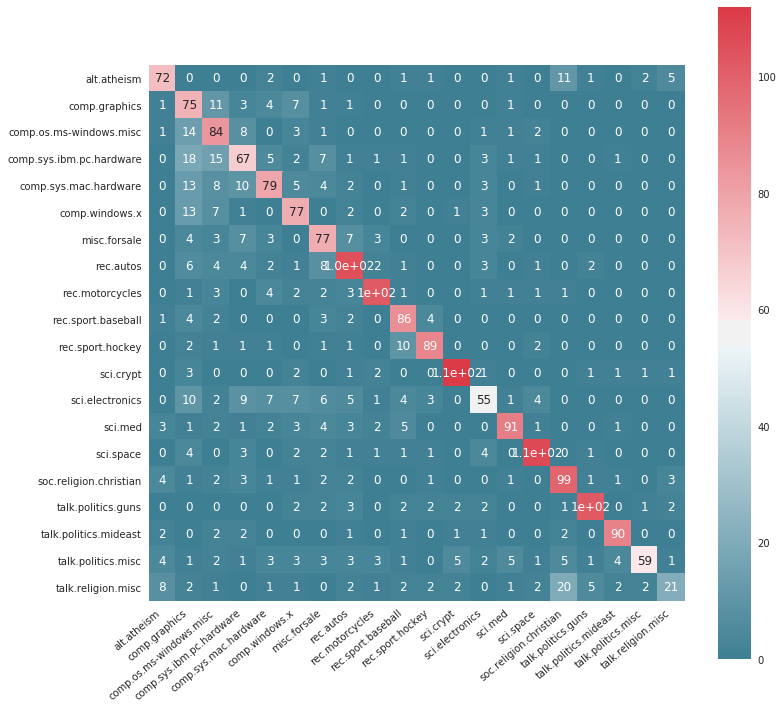

In [43]:
y_predict = clf.predict(X_val)
plot_confusion_matrix(np.asarray(confusion_matrix(y_val, y_predict)),figsize=(12,12))

In addition, it can be interesting to give some numeric accuracy measures using the accuracy and the kappa score:

In [44]:
# accuracy measures
from sklearn import metrics
def print_accuracies(y_val, y_predict):
    print("Kappa: %.3f" % metrics.cohen_kappa_score(y_val, y_predict))
    print("Overall Accuracy: %.3f" % metrics.accuracy_score(y_val, y_predict))
    
print_accuracies(y_val, y_predict)

Kappa: 0.714
Overall Accuracy: 0.729


#### Grid search to find the best parameters
The following configurations were tested, starting from a high range of possible values and gradually narrowing down the parameters to be tested:

```python
parameters = {'max_depth':[10, 20, 50, 100], 'n_estimators':[10, 20, 50, 100]}
# {'max_depth': 100, 'n_estimators': 100}
```
Better results are achieved with a higher depth and more estimators, so we increased: both

```python
parameters = {'max_depth':[100, 500, 1000], 'n_estimators':[20, 50, 100]}
# {'max_depth': 1000, 'n_estimators': 100}
```
Again, we got better results with a higher number of estimators and a greater depth, so we increased the range to test:
```python
parameters = {'max_depth':[800, 1000, 1500], 'n_estimators':[80, 120, 180]}
# {'max_depth': 800, 'n_estimators': 180}
```
We now see that we get better results with more estimators and less depth, so we increase the number of estimators and decrease the maximum depth:
```python
parameters = {'max_depth':[200, 500, 800], 'n_estimators':[200, 300, 500]}
# {'max_depth': 500, 'n_estimators': 500}
```
A depth of around 500 seems to be optimal for n_estimators = 500, let's see if this is also true for a higher number of estimators:
```python
parameters = {'max_depth':[200, 500, 800], 'n_estimators':[500, 700, 900]}
# {'max_depth': 500, 'n_estimators': 900}
```
It seems safe to suppose that a higher number of estimators is better up to a certain point and the maximum depth should not exceed 500 splits. We will chose the following optimal parameters for the Random Forest:
- `n_estimators`: 1000
- `max_depth`: 500

Further parameters for grid search:
- `n_jobs = -1` : parallelize, run one jobs on each of the CPU cores (-1 = number of cores)
- `verbose = 2`: print output to track progress in grid search
- `cv = 3` (default): 3-fold cross-validation. 

In [45]:
parameters = {'max_depth':[200, 500, 800],
              'n_estimators':[500, 700, 900]}

grid_search = GridSearchCV(clf, parameters, n_jobs=-1, verbose = 2) # n_jobs: parallelize

In [46]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] max_depth=200, n_estimators=500 .................................
[CV] max_depth=200, n_estimators=500 .................................
[CV] max_depth=200, n_estimators=500 .................................
[CV] max_depth=200, n_estimators=700 .................................
[CV] max_depth=200, n_estimators=700 .................................
[CV] max_depth=200, n_estimators=700 .................................
[CV] max_depth=200, n_estimators=900 .................................
[CV] max_depth=200, n_estimators=900 .................................
[CV] .................. max_depth=200, n_estimators=500, total= 4.5min
[CV] .................. max_depth=200, n_estimators=500, total= 4.5min
[CV] max_depth=200, n_estimators=900 .................................
[CV] max_depth=500, n_estimators=500 .................................
[CV] .................. max_depth=200, n_estimators=500, total= 4.6min
[CV] max_depth=50

[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 23.8min finished


{'max_depth': 800, 'n_estimators': 500}

#### Train and test of the classifier with these parameters

In [47]:
clf_opt = RandomForestClassifier(n_estimators=1000, max_depth=500, n_jobs = -1, verbose=1)
clf_opt.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.0min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=500, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [48]:
y_predict_opt = clf_opt.predict(X_val)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.1s finished


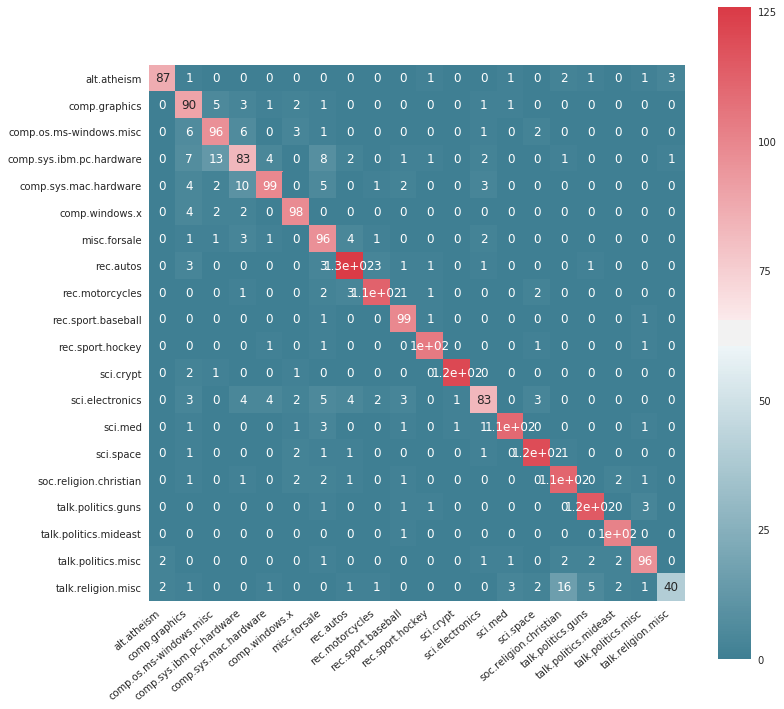

In [49]:
plot_confusion_matrix(np.asarray(confusion_matrix(y_val, y_predict_opt)),figsize=(12,12))

In [50]:
print_accuracies(y_val, y_predict_opt)

Kappa: 0.872
Overall Accuracy: 0.878


This matrix shows that the prediction is far more accurate using the tuned hyperparameters found by grid search.
Blue is darker outside of the diagonal (less errors of classification). Interestingly there are more confusions between `talk.religion.misc` and `soc.religion.christian` but overall, the model has improved. We could give a greater weight to this class in the Random Forest model training if we wanted to.

#### Feature importance

Now let's look at the `feature_importances_` of the classifier and see the correspondance with terms in the text.

We'll look at the 20 more important features and the corresponding terms.

In [51]:
ind = list(np.argsort(clf_opt.feature_importances_)[-20:])

In [52]:
fnames = np.asarray(itemgetter(*ind)(feature_names))

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

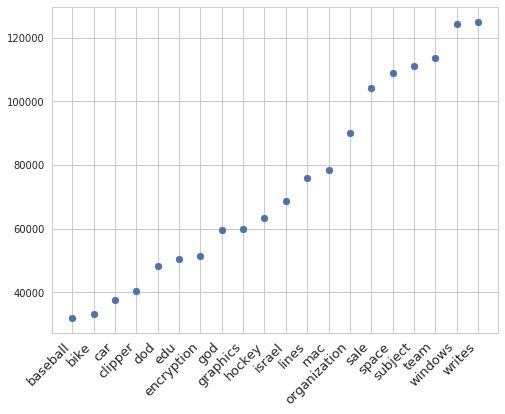

In [53]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)
plt.scatter(fnames,ind)
plt.xticks(rotation=45, horizontalalignment='right', fontsize=13)

Those are quite caracteristic words. For example, if a text contains the word Israel, it has great chance to be classified in `talk.politics.mideast` or windows in `comp.os.ms-windows.misc`. We can understand why those are the most important features of the model.